# Phylogenetic generalized least squares analysis in R

We start by importing packages:

In [9]:
library(ape)
library(phytools)
library(geiger)
library(nlme)
library(caper)
library(dplyr)
library(IRdisplay)

We now read in the data to analyze. For pGLS, we will work with species means, so we prepare that dataframe here.

In [2]:
df<-read.csv("20190322_supp_table_2.csv", header=TRUE)
df_ave = data.frame(aggregate(select(df, 'mass..g.', 'area..mm.2.', 'depth..mm.'), list(df$species, df$spiracle), mean))
colnames(df_ave) = c('species', 'spiracle', 'mass.g', 'area.mm.2', 'depth.mm')
print('Raw dataframe')
head(df)
print('Species averaged dataframe')
head(df_ave, 15)

[1] "Raw dataframe"


X,subfamily,species,sex,mass..g.,spiracle,area..mm.2.,depth..mm.
0,Cetoniinae,Goliathus goliathus,M,16.280,6,0.27440814,2.5126476
1,Cetoniinae,Goliathus goliathus,F,18.150,6,0.13494870,1.6061889
2,Cetoniinae,Coelorrhina hornimani,M,1.130,6,0.21213130,0.5538330
3,Cetoniinae,Dicronorrhina derbyana,M,2.120,6,0.03953171,0.4733690
4,Cetoniinae,Dicronorrhina derbyana,F,2.145,6,0.04970094,0.4963200
5,Cetoniinae,Mecynorrhina torquata,M,6.875,6,0.10613305,0.6430775


[1] "Species averaged dataframe"


species,spiracle,mass.g,area.mm.2,depth.mm
Coelorrhina hornimani,1,1.1300,0.135347094,0.4167170
Cyclocephala borealis,1,0.1077,0.026487743,0.2034912
Dicronorrhina derbyana,1,2.1325,0.084960578,0.5101785
Dynastes hercules,1,26.3500,0.752373452,0.9172193
Eudicella euthalia,1,2.1835,0.095080559,0.5244083
Goliathus goliathus,1,17.2150,1.247407279,1.2819426
Mecynorrhina torquata,1,6.8750,0.425595818,0.9853606
Popilia japonica,1,0.1312,0.007093503,0.2247976
Protaetia orientalis,1,1.3750,0.099676547,0.2049203
Trypoxylus dichotomus,1,6.4149,0.115793934,0.5502965


To do pGLS, we need a phylogenetic tree of our study species. We will manually define that here and visualize it to makes sure it matches the tree we spliced together and show [here](https://julianmwagner.github.io/spiracle_scaling/studydesign/study_design.html).

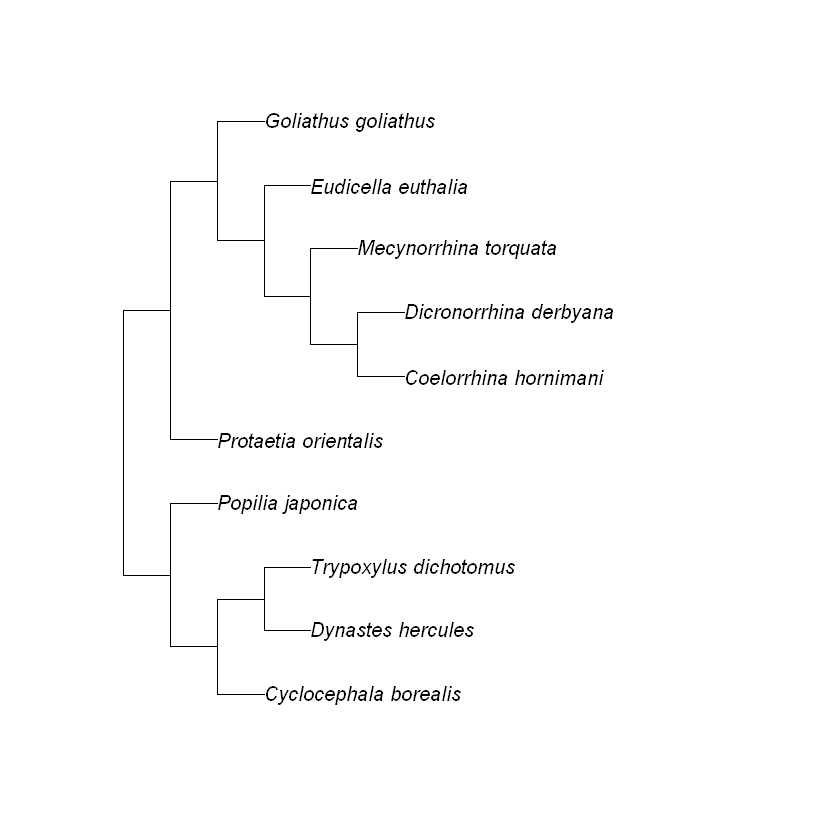

In [3]:
tree4 <- read.tree(text="(((Cyclocephala_borealis:1.0,(Dynastes_hercules:1.0,Trypoxylus_dichotomus:1.0):1.0):1.0,Popilia_japonica:1.0):1.0,(Protaetia_orientalis:1.0,((((Coelorrhina_hornimani:1.0,Dicronorrhina_derbyana:1):1,Mecynorrhina_torquata:1.0):1,Eudicella_euthalia:1.0):1,Goliathus_goliathus:1.0):1.0):1.0):1.0;")
plot.phylo(tree4)

Looks good! We will now sort the data so as to match the tree for analysis.

In [4]:
spir <- 'T'
tree <- tree4
digits <- 5
tips <- gsub("_", " ", tree$tip.label)
tree$tip.label <- tips
df_ave_sort = df_ave[df_ave['spiracle'] == spir,][match(tips, df_ave[df_ave['spiracle'] == spir,]$species),]
df_ave_sort$log_area_dist <- round(log10(df_ave_sort$area.mm.2/df_ave_sort$depth.mm), digits = digits)
df_ave_sort$log_area <- round(log10(df_ave_sort$area.mm.2), digits = digits)
df_ave_sort$log_mass <- round(log10(df_ave_sort$mass.g), digits = digits)
df_ave_sort$log_dist <- round(log10(df_ave_sort$depth.mm), digits = digits)
df_ave_sort

,species,spiracle,mass.g,area.mm.2,depth.mm,log_area_dist,log_area,log_mass,log_dist
72,Cyclocephala borealis,T,0.1077,0.024085839,0.1898423,-0.89663,-1.61824,-0.96778,-0.72161
74,Dynastes hercules,T,26.3500,0.741523838,1.0788964,-0.16285,-0.12987,1.42078,0.03298
80,Trypoxylus dichotomus,T,6.4149,0.195184039,0.5859995,-0.47745,-0.70956,0.80719,-0.23210
78,Popilia japonica,T,0.1312,0.009278006,0.1749687,-1.27551,-2.03255,-0.88207,-0.75704
79,Protaetia orientalis,T,1.3750,0.064890325,0.3065776,-0.67436,-1.18782,0.13830,-0.51346
71,Coelorrhina hornimani,T,1.1300,0.093885056,0.4799060,-0.70856,-1.02740,0.05308,-0.31884
73,Dicronorrhina derbyana,T,2.1325,0.083087225,0.6190670,-0.87220,-1.08047,0.32889,-0.20826
77,Mecynorrhina torquata,T,6.8750,0.213193241,1.0063677,-0.67398,-0.67123,0.83727,0.00276
75,Eudicella euthalia,T,2.1835,0.077483447,0.5905602,-0.88206,-1.11079,0.33915,-0.22874
76,Goliathus goliathus,T,18.1500,1.234093631,1.1683909,0.02376,0.09135,1.25888,0.06759


This also looks good, though is reversed as compared to the branch tips on the tree. We hence reverse the dataframe an then load it into an object for use with the package that does pGLS.

In [5]:
comparative_data <- comparative.data(tree, df_ave_sort[nrow(df_ave_sort):1,], species)

With this data structure in hand, we can run the model. We will also run a linear regression with ordinary least squares to compare to the phylogenetic model. We use the maximum likelihood to select the $\lambda$ parameter that describes the strength of the phylogenetic covariance. We will look more into this parameter later.

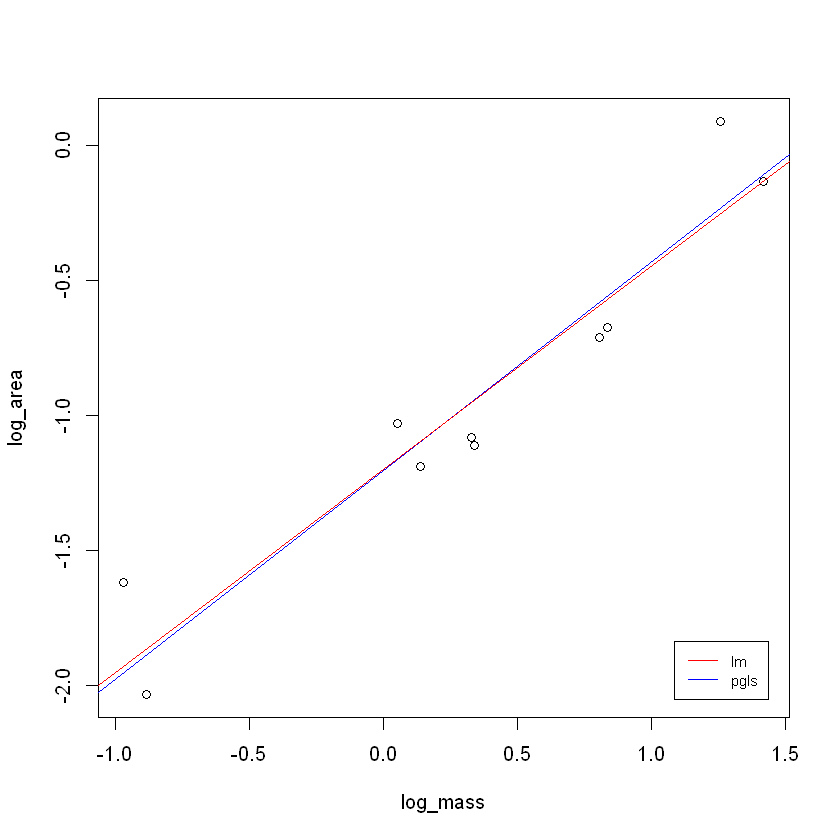

In [6]:
model1<-pgls(log_area~log_mass, comparative_data, lambda="ML")
model2<-lm(log_area~log_mass, df_ave_sort)
plot(log_area~log_mass, data=df_ave_sort)
abline(model1, col='blue')
abline(model2, col='red')
legend ("bottomright",legend=c("lm", "pgls"),cex =0.75,lty=c(1,1,1),inset=0.03, seg.len = 2, col=c('red', 'blue'),bg="white")

This looks good! The two models give similar outputs. We now define a function to generate such a figure for models, which will be useful when we wish to make a bunch of models for each spiracle. 

In [7]:
panel_fig <- function(model1, model2, data, o, reg, slope, x, y){
    
  #pdf(paste("./plots/", paste(paste(o, reg, sep=""), "_regressions.pdf", sep = ""), sep = ""), width=10, height=4)
  png(paste("./plots/", paste(paste(o, reg, sep=""), "_regressions.png", sep = ""), sep = ""), width=1000, height=400)
  par(mfrow=c(1,2),mar = c(2,3,2,0))
  par(lwd=1)
  par(mar = c(3,3,2,1) + 0.1)
  
  
 plot(x, y,main=paste("Spiracle ", o, " Slopes"))
 for(ent in seq(-6,4,(max(y)-min(y))/20 )) {
   abline(coef =c(ent,slope), col=rgb(red = 0.2,green = 0.2,blue = 0.2,alpha=0.1))
 }
 abline(model1,col='blue')
 abline(model2,col='red')
 
 title(ylab=paste("log(", reg, ")"), line=2, cex.lab=1)
 title(xlab="log(mass)", line=2, cex.lab=1)
 
 par(font=2)
 #legend ("topleft", legend="d)",bty = "n")
 par(font=1)
 legend ("bottomright",legend=c("isometry","lm", "pgls"),cex =0.75,lty=c(1,1,1),inset=0.03, seg.len = 2,
         col=c(rgb(red = 0.2,green = 0.2,blue = 0.2,alpha=0.1),
               'red',
               'blue'),
         bg="white")
    
  profile_lambda=pgls.profile(model1, which="lambda") # vary lambda
  par(mar=c(7,4,2,2))
  plot(profile_lambda)

  dev.off()
}

prep_data <- function(spir, tree, digits, df_ave) {
    tips <- gsub("_", " ", tree$tip.label)
    tree$tip.label <- tips
    df_ave_sort = df_ave[df_ave['spiracle'] == spir,][match(tips, df_ave[df_ave['spiracle'] == spir,]$species),]
    df_ave_sort$log_area_dist <- round(log10(df_ave_sort$area.mm.2/df_ave_sort$depth.mm), digits = digits)
    df_ave_sort$log_area <- round(log10(df_ave_sort$area.mm.2), digits = digits)
    df_ave_sort$log_mass <- round(log10(df_ave_sort$mass.g), digits = digits)
    df_ave_sort$log_area_2_dist <- round(log10((df_ave_sort$area.mm.2^2)/df_ave_sort$depth.mm), digits = digits)
    df_ave_sort$log_dist <- round(log10(df_ave_sort$depth.mm), digits = digits)
    return(df_ave_sort)
}

We can now loop through all the spiracles and generate figures for each of their morphological values.

In [8]:
spir <- '5'
tree <- tree4
tips <- gsub("_", " ", tree$tip.label)
tree$tip.label <- tips
digits <- 4
df_con <- df_ave

for (spir in c('T', 'S', '1', '2', '3', '4', '5', '6')) {
    
    df_ave_sort <- prep_data(spir, tree, digits, df_ave)
    comparative_data <- comparative.data(tree, df_ave_sort[nrow(df_ave_sort):1,], species)

    model1<-pgls(log_area~log_mass, comparative_data, lambda="ML")
    model2<-lm(log_area~log_mass, df_ave_sort)
    
    model3<-pgls(log_area_dist~log_mass, comparative_data, lambda="ML")
    model4<-lm(log_area_dist~log_mass, df_ave_sort)
    
    model5<-pgls(log_area_2_dist~log_mass, comparative_data, lambda="ML")
    model6<-lm(log_area_2_dist~log_mass, df_ave_sort)
    
    model7<-pgls(log_dist~log_mass, comparative_data, lambda="ML")
    model8<-lm(log_dist~log_mass, df_ave_sort)

    panel_fig(model1, model2, df_ave_sort, spir, "_area", 0.67, df_ave_sort$log_mass, df_ave_sort$log_area)
    panel_fig(model3, model4, df_ave_sort, spir, "_area_over_dist", 0.33, df_ave_sort$log_mass, df_ave_sort$log_area_dist)
    panel_fig(model5, model6, df_ave_sort, spir, "_area_2_over_dist", 1.00, df_ave_sort$log_mass, df_ave_sort$log_area_2_dist)
    panel_fig(model7, model8, df_ave_sort, spir, "_dist", 0.33, df_ave_sort$log_mass, df_ave_sort$log_dist)   
}

With these plots generated, we can visualize them all.

---

## Plot for species averaged mass vs species averaged spiracle area (log transformed)

<img src="./plots/S_area_regressions.png" style="width:900px;"><img src="./plots/T_area_regressions.png" style="width:900px;"><img src="./plots/1_area_regressions.png" style="width:900px;"><img src="./plots/2_area_regressions.png" style="width:900px;"><img src="./plots/3_area_regressions.png" style="width:900px;"><img src="./plots/4_area_regressions.png" style="width:900px;"><img src="./plots/5_area_regressions.png" style="width:900px;"><img src="./plots/6_area_regressions.png" style="width:900px;">

---

## Plot for species averaged mass vs species averaged spiracle depth (log transformed)

<img src="./plots/S_dist_regressions.png" style="width:900px;"><img src="./plots/T_dist_regressions.png" style="width:900px;"><img src="./plots/1_dist_regressions.png" style="width:900px;"><img src="./plots/2_dist_regressions.png" style="width:900px;"><img src="./plots/3_dist_regressions.png" style="width:900px;"><img src="./plots/4_dist_regressions.png" style="width:900px;"><img src="./plots/5_dist_regressions.png" style="width:900px;"><img src="./plots/6_dist_regressions.png" style="width:900px;">

---

## Species averaged mass vs $\frac{\mathrm{species\,averaged\,area}}{\mathrm{species\,averaged\,depth}}$ (log transformed)
<img src="./plots/S_area_over_dist_regressions.png" style="width:900px;"><img src="./plots/T_area_over_dist_regressions.png" style="width:900px;"><img src="./plots/1_area_over_dist_regressions.png" style="width:900px;"><img src="./plots/2_area_over_dist_regressions.png" style="width:900px;"><img src="./plots/3_area_over_dist_regressions.png" style="width:900px;"><img src="./plots/4_area_over_dist_regressions.png" style="width:900px;"><img src="./plots/5_area_over_dist_regressions.png" style="width:900px;"><img src="./plots/6_area_over_dist_regressions.png" style="width:900px;">

---

## Species averaged mass vs $\frac{(\mathrm{species\,averaged\,area})^2}{\mathrm{species\,averaged\,depth}}$ (log transformed)
<img src="./plots/S_area_2_over_dist_regressions.png" style="width:900px;"><img src="./plots/T_area_2_over_dist_regressions.png" style="width:900px;"><img src="./plots/1_area_2_over_dist_regressions.png" style="width:900px;"><img src="./plots/2_area_2_over_dist_regressions.png" style="width:900px;"><img src="./plots/3_area_2_over_dist_regressions.png" style="width:900px;"><img src="./plots/4_area_2_over_dist_regressions.png" style="width:900px;"><img src="./plots/5_area_2_over_dist_regressions.png" style="width:900px;"><img src="./plots/6_area_2_over_dist_regressions.png" style="width:900px;">

We can see that the phylogenetic and non-phylogenetic models tend to return very similar results to each other. Also note the weakly peaked distribution in log-likelihood space for the $\lambda$ parameter. No model gave a value for $\lambda$ that was significantly different than zero (which represents no phylogenetic signal). The large areas of parameter space that give similar likelihood for the parameter suggests that the data is not much informing this parameter value, that is, it is non-identifiable. We Further show that the parameter is non-identifiable with a Bayesian analyis, but already can see it here as well. Selecting a single maximum likelihood value for the $\lambda$ based on these likelihood functions seems dubious, and hence we opt to not use the phylogenetic covariance model for our analyses. 